## <b>This noteboook aims to extract,Transform and Load the crime data [LINK](https://www.bocsar.nsw.gov.au/Pages/bocsar_crime_stats/bocsar_lgaexceltables.aspx)</b>
***

### <b>Moduels required </b>

In [3]:
import pandas as pd
import glob
import os 
import numpy as np
import re

import configparser
from etl_helper import * 


import psycopg2
import configparser

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import requests
# from urllib3.exceptions import InsecureRequestWarning
# from urllib3 import disable_warnings
import pandas as pd
import numpy as np
from functools import reduce

### <b>Code to feature selection and  transform the raw crime data file </b>

In [ ]:
import os 
currentDirectory = os.getcwd()

crimeDataRaw  = pd.read_csv(f'{currentDirectory}/data/bocsarCrimeData.csv')   #extract crimeData.zip in the data folder  

crimeDataRaw  = crimeDataRaw[['Postcode','Offence category','Subcategory','Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021',
       'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 2021']]

crimeDataRaw['TotalCrimes'] =  crimeDataRaw[['Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021',
       'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 2021']].sum( axis=1)

crimeDataRaw.to_csv(f'{currentDirectory}/data/crime_data_transformed.csv',index=False)

### <b>Bocsar ETL of Juveniles Victims by LGA</b>

In [ ]:
root='https://www.bocsar.nsw.gov.au'
URL = "https://www.bocsar.nsw.gov.au/Pages/bocsar_crime_stats/bocsar_lgaexceltables.aspx"
page = requests.get(URL, verify=False)
print(page.content)
print(page.text)

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

In [ ]:
table=soup.table

pd_all_link=[]
all_res = []

#create a list of the excel links and extract from each excel all the data
for a in table.find_all('a', href=True):
    print("Found the URL:", a['href'])
    pd_all_link.append(root+a['href'])
    if(a['href']!="/Documents/lga/jerilderielga.xlsx"):
        xl = pd.ExcelFile(root+a['href'],)
        #select only victims
        victims = xl.parse('Victims', nrows = 24, header = 5) 
        #victims['lga']=a['href'].split("/")[3].split('.')[0]
        if(str(a.contents[0]).startswith('<strong>')):
            victims['lga']=a.strong.contents[0].strip() #nsw comes with <strong>
            all_res.append(victims)
        else:
            victims['lga']=a.contents[0].strip() 
            all_res.append(victims)
    
#all dataframes as one dataframe
df = pd.concat(all_res)


#### Data Cleaning 

In [ ]:
#Fill NA in the first column with the values of the previous value
df[["Victim's gender"]]=df[["Victim's gender"]].fillna(method='ffill')

In [ ]:

#Replace 'na' with 1 ->BOCSAR Note: To protect the identity of individuals, 'na' indicates that the age category has a count that falls between 1 and 4 inclusive.
df.dtypes
import numpy as np
df=df.replace('na', 1) #lower limit (underestimating)

In [ ]:
# Select all victims with age between 0-17
df_grouped=df.copy()
df_grouped=df_grouped[df_grouped["Victim's gender"] != "Total"]
df_grouped=df_grouped[df_grouped["Victim's age"] != "Total"]
df_grouped=df_grouped[df_grouped["Victim's age"] == "0 - 17"]

In [ ]:
#Group by to calculate the sum
df_grouped=df_grouped.groupby(["lga"]).sum()
df_grouped=df_grouped.drop(columns=["Victim's gender", "Victim's age"])
print(df_grouped)

In [ ]:
df_grouped.to_excel('G:/Mi unidad/NSW Offences/Scripts/juv_victims_by_lga_gender_age.xlsx',index=True)

#import configparser
#from etl_helper import * 
#postgresConf = GetConfiguration()
#SendData(crime_Data_raw, table_name='bocsar.juvenile_victims',  if_exists_flag = 'replace')

### <b>CODE ALTERED TO EXTRACT OFFENDERS DATA ( ARAVIND )</b>

In [ ]:
root='https://www.bocsar.nsw.gov.au'
URL = "https://www.bocsar.nsw.gov.au/Pages/bocsar_crime_stats/bocsar_lgaexceltables.aspx"
page = requests.get(URL, verify=False)


#---------------------------------------------------------------------------------------------------------------------
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())


#---------------------------------------------------------------------------------------------------------------------
#Extract the links from the lga table, open the xlsx, extract the juvenile data

table=soup.table
pd_all_link=[]
all_res = []

#create a list of the excel links and extract from each excel all the data
for a in table.find_all('a', href=True):
    print("Found the URL:", a['href'])
    pd_all_link.append(root+a['href'])
    if(a['href']!="/Documents/lga/jerilderielga.xlsx"):
        xl = pd.ExcelFile(root+a['href'],)
        #select only victims
        victims = xl.parse('Offenders', nrows = 27, header = 5) 
        #victims['lga']=a['href'].split("/")[3].split('.')[0]
        if(str(a.contents[0]).startswith('<strong>')):
            victims['lga']=a.strong.contents[0].strip() #nsw comes with <strong>
            all_res.append(victims)
        else:
            victims['lga']=a.contents[0].strip() 
            all_res.append(victims)
    
#all dataframes as one dataframe
df = pd.concat(all_res)

#---------------------------------------------------------------------------------------------------------------------


### Data Cleaning
#Fill NA in the first column with the values of the previous value 
df[["Alleged offender's gender"]]=df[["Alleged offender's gender"]].fillna(method='ffill')


#---------------------------------------------------------------------------------------------------------------------

#Replace 'na' with 1 ->BOCSAR Note: To protect the identity of individuals, 'na' indicates that the age category has a count that falls between 1 and 4 inclusive.
#df.dtypes

df=df.replace('na', 1) #lower limit (underestimating)



#---------------------------------------------------------------------------------------------------------------------
#Select all victims with age between 10-17

df_grouped=df.copy(deep=True)
df_grouped = df_grouped[(df_grouped["Alleged offender's gender"] != "Total") & (df_grouped["Alleged offender's age"] != "Total") & (df_grouped["Alleged offender's age"] == "10 - 17")  ] 

#Group by to calculate the sum
df_grouped[df_grouped.lga == 'Albury']
df_grouped=df_grouped.drop(columns=["Alleged offender's gender", "Alleged offender's age"])
df_grouped=df_grouped.groupby(["lga"]).sum()


#---------------------------------------------------------------------------------------------------------------------

import os 
currentDirectory = os.getcwd()
df_grouped.to_csv(f'{currentDirectory}/data/lga.offenders_10_17.csv')


## Extracting and making crime data for 2016 from bocsar map data 

In [116]:
def forEachCsv(path,year,offenceName):
    df = pd.read_csv(path , skiprows=1 , usecols= ['Unnamed: 0',f'Year to June {year}'] )
    #display(df)
    df = df.iloc[2:]
    df.columns = [ 'LGA' , f'{offenceName}.count'  ]
    df.replace("1 to 4", 1, inplace= True)
    df.reset_index( inplace = True , drop=True) 
    return df
    


In [118]:
list_of_df = []
for each in glob.glob('/Users/icmec/Downloads/crime maps/*.csv'):
    fileName = os.path.basename(each)
    requiredId,_ = fileName.split('.')
    dataf = forEachCsv(each,2016,requiredId)
    list_of_df.append(dataf)


In [119]:
crime_data_2016 = reduce(lambda df1,df2: pd.merge(df1,df2,on='LGA'), list_of_df)
crime_data_2016.drop( crime_data_2016[crime_data_2016['LGA']  == 'Unincorporated Far West'].index , axis=0,inplace=True )

crime_data_2016.replace( 'Ku-Ring-Gai', 'Ku-ring-gai' , inplace=True)
crime_data_2016.replace( 'Cootamundra-Gundagai', 'Cootamundra-Gundagai Regional' , inplace=True)

crime_data_2016.set_index('LGA',inplace = True)
crime_data_2016 = crime_data_2016.astype( 'int64' )
crime_data_2016.reset_index( inplace=True )
crime_data_2016
crime_data_2016.to_csv('/Users/icmec/Documents/project_census_crime/data/lga/2016_crime_data.csv')


## Analysing the difference between the 2016 and 2021 crime

In [261]:
def forEachCsv(path,offenceName):
    df = pd.read_csv(path , skiprows=1 , usecols= ['Unnamed: 0','Year to June 2016','Year to June 2021'] )
    #display(df)
    df = df.iloc[2:]
    df.columns = [ 'LGA' , f'{offenceName}.2016',f'{offenceName}.2021'  ]
    df.replace("1 to 4", 1, inplace= True)
    df.reset_index( inplace = True , drop=True) 
    return df
    

In [262]:
list_of_df = []
for each in glob.glob('/Users/icmec/Downloads/crime maps/*.csv'):
    fileName = os.path.basename(each)
    requiredId,_ = fileName.split('.')
    dataf = forEachCsv(each,requiredId)
    list_of_df.append(dataf)


In [ ]:
#crime_data_2016_2021 = reduce(lambda df1,df2: pd.merge(df1,df2,on='LGA'), list_of_df)
#rime_data_2016_2021.set_index('LGA',inplace=True)
#crime_data_2016_2021 = crime_data_2016_2021.astype('int32' )
crime_data_2016_2021.dtypes

In [277]:
crime_data_2016_2021

,arson.2016,arson.2021,blackmail_and_extortion.2016,blackmail_and_extortion.2021,homicide.2016,homicide.2021,domestic_violence_related_assault.2016,domestic_violence_related_assault.2021,sexual_offences.2016,sexual_offences.2021,...,breach_apprehended_violence_order.2016,breach_apprehended_violence_order.2021,robbery.2016,robbery.2021,other_offences_against_the_person.2016,other_offences_against_the_person.2021,abduction_and_kidnapping.2016,abduction_and_kidnapping.2021,nondomestic_violence_related_assault.2016,nondomestic_violence_related_assault.2021
LGA,,,,,,,,,,,,,,,,,,,,,
Albury,0,0,0,0,0,0,27,32,89,104,...,13,16,1,0,1,1,0,1,55,90
Armidale Regional,0,0,0,0,0,0,25,25,51,89,...,8,14,1,0,1,1,0,0,34,48
Ballina,0,0,0,1,0,0,10,13,44,62,...,8,5,1,1,0,1,1,1,33,20
Balranald,0,0,0,0,0,0,1,1,9,1,...,0,1,0,0,0,0,0,0,1,0
Bathurst Regional,0,0,0,0,0,0,31,58,73,121,...,15,15,1,1,1,1,1,0,45,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wingecarribee,0,0,0,0,0,0,12,7,79,95,...,7,7,0,1,0,0,0,0,16,23
Wollondilly,0,0,0,0,0,0,18,23,74,61,...,0,1,1,1,1,1,1,0,32,19
Wollongong,0,0,0,0,0,0,114,84,260,274,...,30,53,9,10,1,5,1,1,158,144


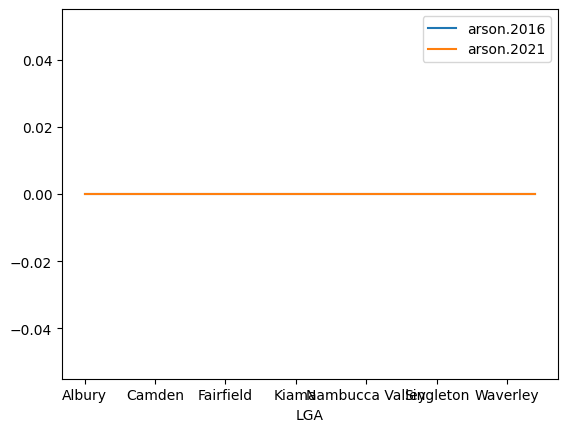

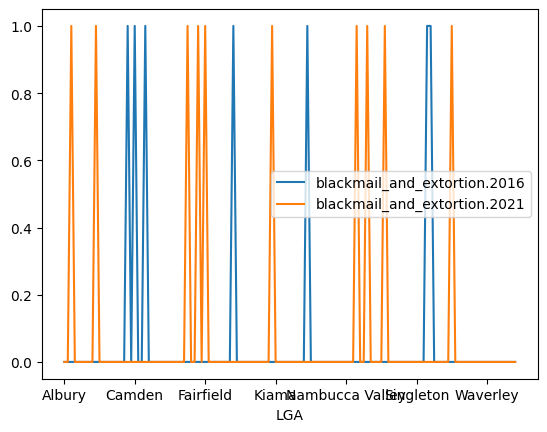

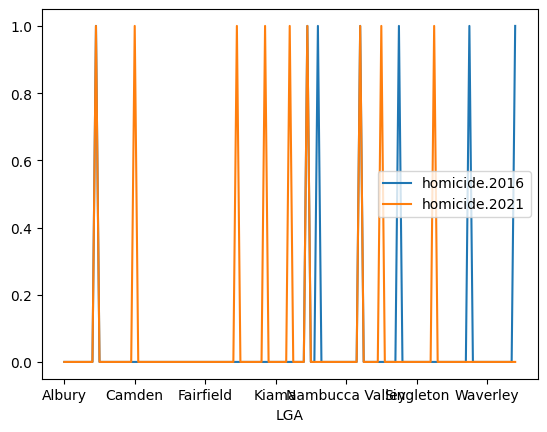

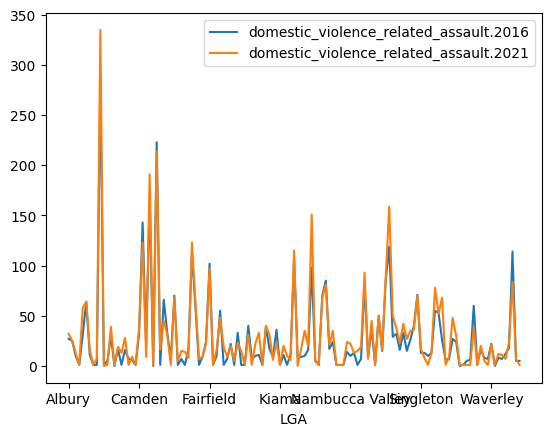

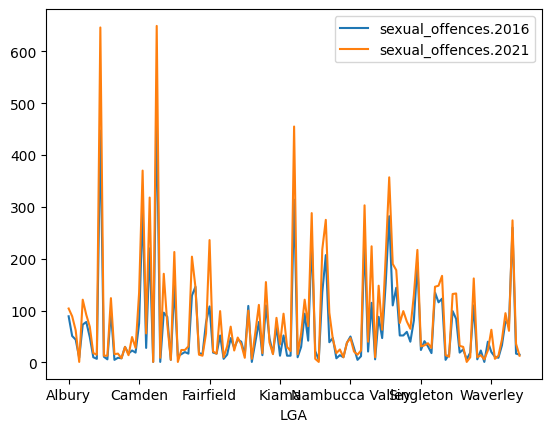

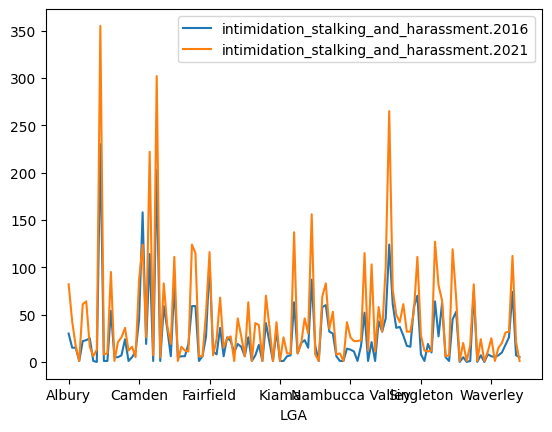

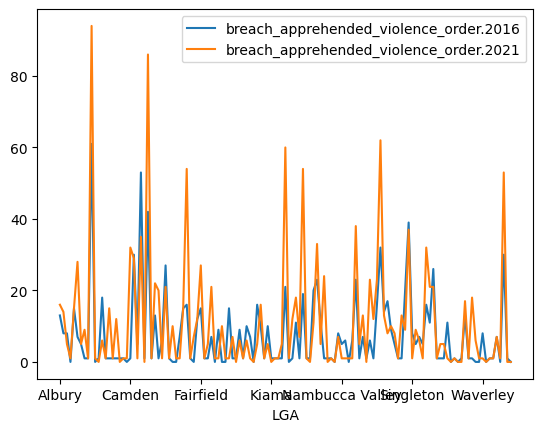

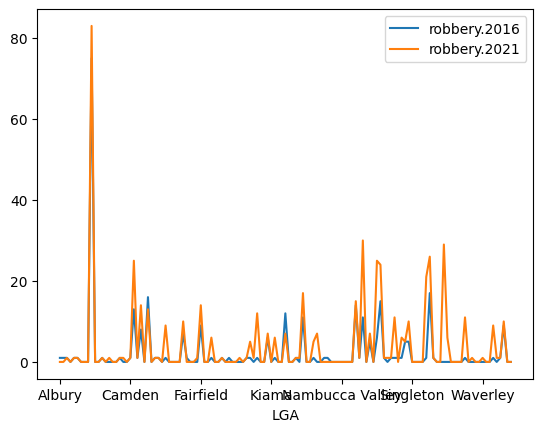

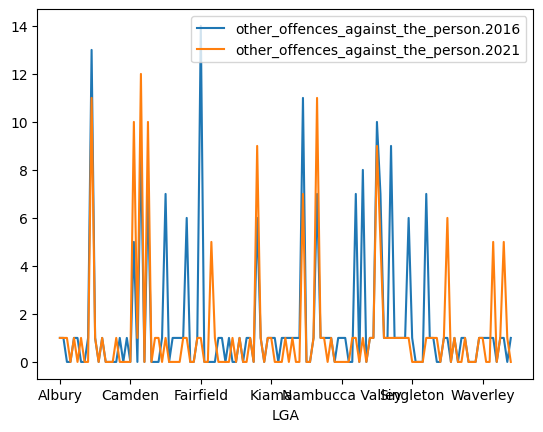

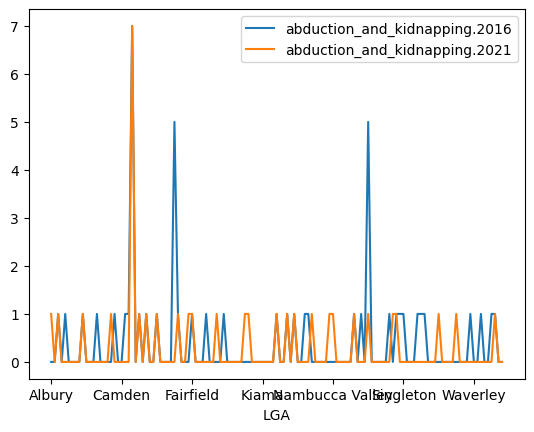

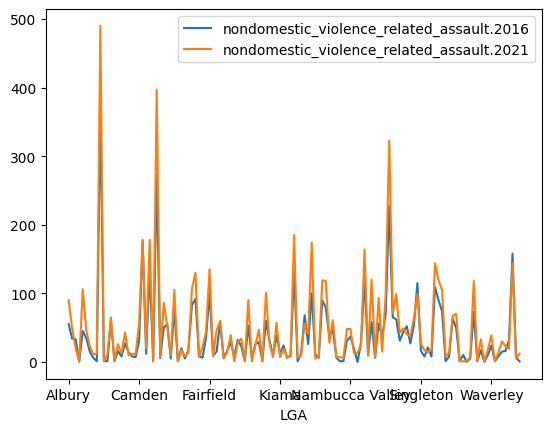

In [279]:
for each in range(0,22,2):
    crime_data_2016_2021.iloc[:,each:each+2].plot()

merge data

In [151]:
# lga_census_2016 = pd.read_csv('/Users/icmec/Documents/project_census_crime/data/lga/2016_census.gcp_all.lga.csv' , index_col=0 )
# lga_codes_names = pd.read_csv('/Users/icmec/Documents/project_census_crime/data/lga/lga_code_and_names.csv')
# lga_census_2021 = pd.read_csv('/Users/icmec/Documents/project_census_crime/data/lga/2021_census.gcp_all_juvenile_victims_with_names.lga.csv')

# lga_census_2016['lga_code_2016'] =  lga_census_2016['lga_code_2016'].str.extract('(\d+)')
# lga_census_2016['lga_code_2016'] = lga_census_2016['lga_code_2016'].astype(int)

# display(lga_census_2016)
# display(lga_codes_names)

# print( set( lga_census_2016['lga_code_2016'] ) - set(lga_codes_names['lga_code_2021']) ) #codes that are exclusively in 2016 
# print('+'*50)
# print(  set(lga_codes_names['lga_code_2021']) -  set( lga_census_2016['lga_code_2016'] ))     #codes that are exclusively in 2021

# #merging to get LGA names 
# lga_census_2016_with_names =  lga_codes_names.merge(lga_census_2016 , left_on='lga_code_2021',right_on='lga_code_2016',how='inner'  )
# #merging the LGA census and crime data
# lga_census_2016_with_names.drop('lga_code_2021',axis=1,inplace=True)
# lga_census_2016_with_names_crime = lga_census_2016_with_names.merge(crime_data_2016,left_on='Unnamed: 0',right_on='LGA',how='inner')
# lga_census_2016_with_names_crime

# #computing the rate of crime 
# for each in crime_data_2016.columns[1:]:
#     name, _ = each.split('.')
#     print(name)
#     lga_census_2016_with_names_crime[ f'{name}.rate' ] =  lga_census_2016_with_names_crime[each] / lga_census_2016_with_names_crime['g01.tot_p_p']
# lga_census_2016_with_names_crime.rename( columns = { 'Unnamed: 0':'lga_name' } , inplace = True )
# lga_census_2016_with_names_crime
# lga_census_2016_with_names_crime.to_csv( '/Users/icmec/Documents/project_census_crime/data/lga/2016_census.gcp_all_juvenile_victims_with_names.lga.csv' )

# transformed_ = lga_census_2016_with_names_crime.T
# transformed_.columns = transformed_.iloc[0]
# transformed_
# SendData( transformed_.iloc[1:] , table_name= '2016_census.gcp_all_juvenile_victims.lga' ,schema_name='prod',if_exists_flag='replace' )

In [252]:
 
# lga_census_2016_with_names_crime.drop('LGA' , axis=1 , inplace= True)
# transformed_ = lga_census_2016_with_names_crime.T
# transformed_.columns = transformed_.iloc[0]
# transformed_1 =  transformed_.iloc[1:].replace('..',np.nan)
# transformed_1.astype('float')
# transformed_1.reset_index()
# SendData( transformed_1 , table_name= '2016_census.gcp_all_juvenile_victims.lga' ,schema_name='prod',if_exists_flag='replace' , index=True )
# # SendData( transformed_.iloc[1:] , table_name= '2016_census.gcp_all_juvenile_victims.lga' ,schema_name='prod',if_exists_flag='replace' )

lga_name,Albury,Ballina,Balranald,Bathurst Regional,Bega Valley,Bellingen,Berrigan,Blacktown,Bland,Blayney,...,Warrumbungle Shire,Waverley,Weddin,Wentworth,Willoughby,Wingecarribee,Wollondilly,Wollongong,Woollahra,Yass Valley
lga_name,Albury,Ballina,Balranald,Bathurst Regional,Bega Valley,Bellingen,Berrigan,Blacktown,Bland,Blayney,...,Warrumbungle Shire,Waverley,Weddin,Wentworth,Willoughby,Wingecarribee,Wollondilly,Wollongong,Woollahra,Yass Valley
lga_code_2016,10050,10250,10300,10470,10550,10600,10650,10750,10800,10850,...,18020,18050,18100,18200,18250,18350,18400,18450,18500,18710
g32.opds_separate_house_dwellings,15634,11223,734,12166,10934,4466,2904,78774,2066,2507,...,3299,4160,1365,2163,12077,16121,14179,51367,4500,5185
g32.opds_separate_house_persons,39601,29084,1907,32367,25770,10684,6728,257809,4970,6378,...,7714,13126,3072,5495,37539,40550,43859,145913,14019,14237
g32.opds_sd_r_t_h_th_1_sty_dwgs,2907,2129,15,1137,834,184,107,6231,9,30,...,45,2148,51,38,865,764,589,4016,690,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
breach_apprehended_violence_order.rate,0.000255,0.000191,0.0,0.000363,0.00015,0.000079,0.000118,0.000181,0.0,0.000138,...,0.0,0.00012,0.0,0.000147,0.000013,0.000146,0.0,0.000147,0.000018,0.0
robbery.rate,0.00002,0.000024,0.0,0.000024,0.0,0.0,0.0,0.000223,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000013,0.0,0.000021,0.000044,0.0,0.0
other_offences_against_the_person.rate,0.00002,0.0,0.0,0.000024,0.0,0.0,0.000118,0.000039,0.000168,0.0,...,0.000107,0.000015,0.000273,0.000147,0.000013,0.0,0.000021,0.000005,0.0,0.000062
abduction_and_kidnapping.rate,0.0,0.000024,0.0,0.000024,0.0,0.0,0.0,0.000003,0.0,0.0,...,0.000107,0.0,0.0,0.000147,0.0,0.0,0.000021,0.000005,0.0,0.0


## ETL Crime Data for Queensland.

Queensland crime obtained from https://open-crime-data.s3-ap-southeast-2.amazonaws.com/Crime%20Statistics/LGA_Reported_victims_Number.csvf

In [7]:
#rawCrimeFromS3 = pd.read_csv('https://open-crime-data.s3-ap-southeast-2.amazonaws.com/Crime%20Statistics/LGA_Reported_victims_Number.csv', index_col = False , parse_dates= [1]    );

#victims2022 = rawCrimeFromS3[ (rawCrimeFromS3['Month Year'].str.endswith('22'))  & ( rawCrimeFromS3.Age == 'Juvenile'  )  ]
victims2022
#victims2022.groupby(['LGA Name']   ).sum( numeric_only=True )

,LGA Name,Month Year,Age,Sex,Homicide (Murder),Other Homicide,Attempted Murder,Conspiracy to Murder,Manslaughter (excl. by driving),Manslaughter Unlawful Striking Causing Death,...,Other Sexual Offences,Robbery,Armed Robbery,Unarmed Robbery,Other Offences Against the Person,Kidnapping & Abduction etc.,Extortion,Stalking,Life Endangering Acts,Offences Against the Person
1515,Aurukun Shire Council,JAN22,Juvenile,Female,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1516,Aurukun Shire Council,JAN22,Juvenile,Male,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
1517,Aurukun Shire Council,JAN22,Juvenile,Not Stated,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1521,Aurukun Shire Council,FEB22,Juvenile,Female,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1522,Aurukun Shire Council,FEB22,Juvenile,Male,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123076,Yarrabah Shire Council,OCT22,Juvenile,Male,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123077,Yarrabah Shire Council,OCT22,Juvenile,Not Stated,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123081,Yarrabah Shire Council,NOV22,Juvenile,Female,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
123082,Yarrabah Shire Council,NOV22,Juvenile,Male,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [9]:
#victim_crimes = victims2022.groupby(['LGA Name']   ).sum( numeric_only=True )
victim_crimes

,Homicide (Murder),Other Homicide,Attempted Murder,Conspiracy to Murder,Manslaughter (excl. by driving),Manslaughter Unlawful Striking Causing Death,Driving Causing Death,Assault,Grievous Assault,Serious Assault,...,Other Sexual Offences,Robbery,Armed Robbery,Unarmed Robbery,Other Offences Against the Person,Kidnapping & Abduction etc.,Extortion,Stalking,Life Endangering Acts,Offences Against the Person
LGA Name,,,,,,,,,,,,,,,,,,,,,
Aurukun Shire Council,0,0,0,0,0,0,0,36,7,14,...,5,0,0,0,5,2,0,0,3,46
Balonne Shire Council,0,0,0,0,0,0,0,22,0,13,...,0,0,0,0,1,0,0,0,1,24
Banana Shire Council,0,0,0,0,0,0,0,18,0,5,...,25,1,0,1,6,1,0,0,5,52
Barcaldine Regional Council,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,2
Barcoo Shire Council,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whitsunday Regional Council,0,1,0,0,0,0,1,34,0,17,...,15,0,0,0,6,0,0,1,5,70
Winton Shire Council,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
Woorabinda Shire Council,0,0,0,0,0,0,0,20,0,8,...,10,0,0,0,0,0,0,0,0,30


In [13]:
victim_crimes.to_csv('/Users/icmec/Documents/project_census_crime/data/crime/victimeCrimeQld.csv')